Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
% cd '/content/drive/My Drive/Colab Notebooks/c247'

from all_models import *
from all_solvers import *
from all_functions import *

import numpy as np
%matplotlib inline
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from sklearn.model_selection import KFold
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
device = torch.device('cuda' if torch.cuda.is_available() else'cpu')

/content/drive/My Drive/Colab Notebooks/c247


Load Data

In [3]:
# subject data
subject = 8
X_test, y_test, X_train_valid, y_train_valid = import_data_subject(subject)


# DeepConv, trialsize 900, stride 10

-- Fold [1/5] --
Epoch [10], Training loss [1.1334], Training accuracy [50.07%]
Epoch [10], Validation loss [1.7095], Validation accuracy [37.14%]
Epoch [20], Training loss [0.8083], Training accuracy [67.17%]
Epoch [20], Validation loss [2.2953], Validation accuracy [39.85%]
Epoch [30], Training loss [0.5541], Training accuracy [79.36%]
Epoch [30], Validation loss [2.9729], Validation accuracy [32.30%]
Epoch [40], Training loss [0.3904], Training accuracy [85.50%]
Epoch [40], Validation loss [3.2610], Validation accuracy [33.46%]
Epoch [50], Training loss [0.2918], Training accuracy [89.63%]
Epoch [50], Validation loss [3.3425], Validation accuracy [35.59%]
Epoch [60], Training loss [0.2431], Training accuracy [91.94%]
Epoch [60], Validation loss [3.4788], Validation accuracy [36.36%]
Epoch [70], Training loss [0.1913], Training accuracy [93.37%]
Epoch [70], Validation loss [3.3881], Validation accuracy [38.30%]
Epoch [80], Training loss [0.1565], Training accuracy [95.63%]
Epoch [80]

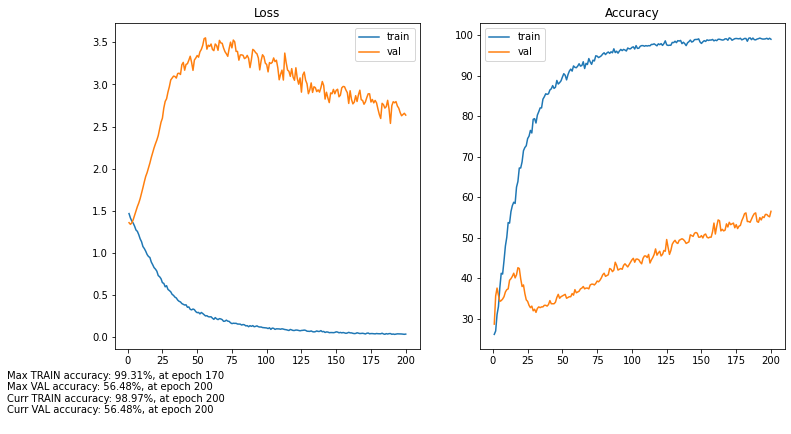

In [4]:
# Set up cross validation folds, and average accuracy tracker
kf = KFold(n_splits=5, random_state=None, shuffle=True)
avg_accuracy=0
kcount = 1

for k_train_index, k_val_index in kf.split(X_train_valid):
  ## Only compute 1 fold due to computation time:
  if kcount==2:
    break
  ## Print fold
  print('-- Fold [{}/5] --'.format(kcount))

  ## Create this fold's dataloader
  SEGMENT = True
  VOTE = False
  window_width = 900
  stride = 10
  num_slices = int((1000-window_width)/stride+1)

  dataloaders = make_dataloaders(k_train_index, k_val_index, X_train_valid, y_train_valid, X_test, y_test, 
                                 cut=SEGMENT, window_width=window_width, stride=stride, num_slices=num_slices)
  
  ## Create model, hyperpatameters, optimizer, loss function 
  weight_decay = 0.001
  model = DeepConv(in_channels=1, classes=4, cnn_drop=0.5, trial_length=window_width).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay=weight_decay)
  loss_fn = nn.CrossEntropyLoss()
  num_epochs = 200

  ## Start training/validating/training
  # set up per epoch accuracy and loss trackers
  loss_tracker = {'train':[], 'val':[]}
  accuracy_tracker = {'train':[], 'val':[]}
  best_model_params = [0, model]

  for epoch in range(num_epochs): 
    logs = {}
    # train on training samples
    model, epoch_loss_avg, epoch_accuracy = train(model, optimizer, loss_fn, dataloaders, device, epoch)
    loss_tracker['train'].append(epoch_loss_avg)
    accuracy_tracker['train'].append(epoch_accuracy)

    # evalutate on validation samples 
    epoch_loss_avg, epoch_accuracy, best_model_params = validate(model, optimizer, loss_fn, dataloaders, device, epoch, best_model_params)
    loss_tracker['val'].append(epoch_loss_avg)
    accuracy_tracker['val'].append(epoch_accuracy)

  # plot train/validation graph
  make_plot(num_epochs, loss_tracker, accuracy_tracker, saveplot=False)
  # get model weights from the epoch with the highest validation accuracy
  _, final_best_model = best_model_params
  thisacc = finaltest(final_best_model, dataloaders, device)
  print('Test accuracy from the best model during fold [{}] is: [{:.2f}%]'.format(kcount, thisacc))
  kcount += 1
  avg_accuracy += thisacc

print('Average test accuracy of 5-fold validation: [{:.2f}]'.format(avg_accuracy/5))

# DeepConv2, trialsize 900, stride 10

-- Fold [1/5] --
Epoch [10], Training loss [1.3637], Training accuracy [38.08%]
Epoch [10], Validation loss [1.3766], Validation accuracy [29.79%]
Epoch [20], Training loss [1.1998], Training accuracy [46.09%]
Epoch [20], Validation loss [1.4179], Validation accuracy [31.33%]
Epoch [30], Training loss [0.9902], Training accuracy [57.59%]
Epoch [30], Validation loss [1.5817], Validation accuracy [29.98%]
Epoch [40], Training loss [0.7912], Training accuracy [68.06%]
Epoch [40], Validation loss [1.8030], Validation accuracy [29.79%]
Epoch [50], Training loss [0.6302], Training accuracy [76.41%]
Epoch [50], Validation loss [1.9822], Validation accuracy [29.79%]
Epoch [60], Training loss [0.4781], Training accuracy [85.80%]
Epoch [60], Validation loss [1.9112], Validation accuracy [31.91%]
Epoch [70], Training loss [0.3544], Training accuracy [90.42%]
Epoch [70], Validation loss [1.9989], Validation accuracy [37.52%]
Epoch [80], Training loss [0.2994], Training accuracy [91.11%]
Epoch [80]

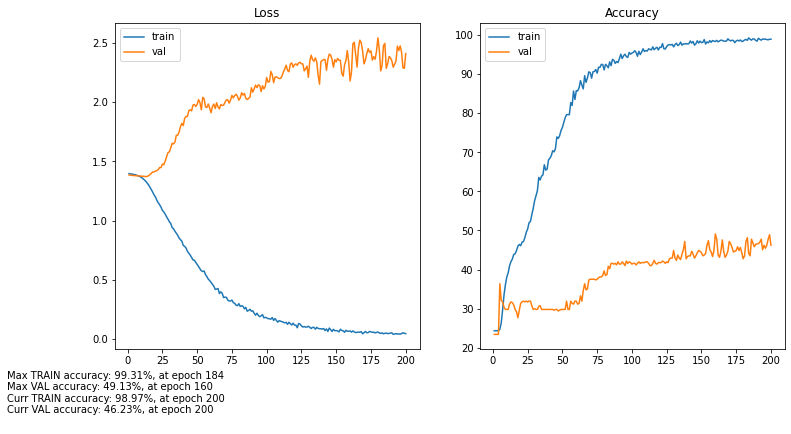

In [5]:
# Set up cross validation folds, and average accuracy tracker
kf = KFold(n_splits=5, random_state=None, shuffle=True)
avg_accuracy=0
kcount = 1

for k_train_index, k_val_index in kf.split(X_train_valid):
  ## Only compute 1 fold due to computation time:
  if kcount==2:
    break
  ## Print fold
  print('-- Fold [{}/5] --'.format(kcount))

  ## Create this fold's dataloader
  SEGMENT = True
  VOTE = False
  window_width = 900
  stride = 10
  num_slices = int((1000-window_width)/stride+1)

  dataloaders = make_dataloaders(k_train_index, k_val_index, X_train_valid, y_train_valid, X_test, y_test, 
                                 cut=SEGMENT, window_width=window_width, stride=stride, num_slices=num_slices)
  
  ## Create model, hyperpatameters, optimizer, loss function 
  weight_decay = 0.001
  model = DeepConv2(in_channels=1, classes=4, cnn_drop=0.5).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay=weight_decay)
  loss_fn = nn.CrossEntropyLoss()
  num_epochs = 200

  ## Start training/validating/training
  # set up per epoch accuracy and loss trackers
  loss_tracker = {'train':[], 'val':[]}
  accuracy_tracker = {'train':[], 'val':[]}
  best_model_params = [0, model]

  for epoch in range(num_epochs): 
    logs = {}
    # train on training samples
    model, epoch_loss_avg, epoch_accuracy = train(model, optimizer, loss_fn, dataloaders, device, epoch)
    loss_tracker['train'].append(epoch_loss_avg)
    accuracy_tracker['train'].append(epoch_accuracy)

    # evalutate on validation samples 
    epoch_loss_avg, epoch_accuracy, best_model_params = validate(model, optimizer, loss_fn, dataloaders, device, epoch, best_model_params)
    loss_tracker['val'].append(epoch_loss_avg)
    accuracy_tracker['val'].append(epoch_accuracy)

  # plot train/validation graph
  make_plot(num_epochs, loss_tracker, accuracy_tracker, saveplot=False)
  # get model weights from the epoch with the highest validation accuracy
  _, final_best_model = best_model_params
  thisacc = finaltest(final_best_model, dataloaders, device)
  print('Test accuracy from the best model during fold [{}] is: [{:.2f}%]'.format(kcount, thisacc))
  kcount += 1
  avg_accuracy += thisacc

print('Average test accuracy of 5-fold validation: [{:.2f}]'.format(avg_accuracy/5))

# Conv1, trialsize 900, stride 10

-- Fold [1/5] --
Epoch [10], Training loss [1.2449], Training accuracy [42.41%]
Epoch [10], Validation loss [1.7155], Validation accuracy [15.47%]
Epoch [20], Training loss [1.0099], Training accuracy [55.72%]
Epoch [20], Validation loss [1.9053], Validation accuracy [25.34%]
Epoch [30], Training loss [0.8079], Training accuracy [66.88%]
Epoch [30], Validation loss [1.8908], Validation accuracy [32.30%]
Epoch [40], Training loss [0.6224], Training accuracy [76.46%]
Epoch [40], Validation loss [2.0400], Validation accuracy [35.78%]
Epoch [50], Training loss [0.4774], Training accuracy [83.00%]
Epoch [50], Validation loss [2.2481], Validation accuracy [39.65%]
Epoch [60], Training loss [0.3420], Training accuracy [87.22%]
Epoch [60], Validation loss [2.2764], Validation accuracy [41.39%]
Epoch [70], Training loss [0.2586], Training accuracy [90.66%]
Epoch [70], Validation loss [2.1278], Validation accuracy [45.84%]
Epoch [80], Training loss [0.2046], Training accuracy [93.07%]
Epoch [80]

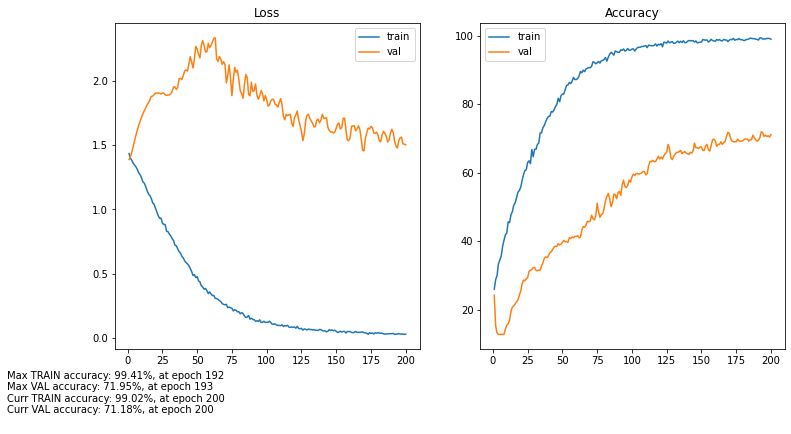

In [6]:
# Set up cross validation folds, and average accuracy tracker
kf = KFold(n_splits=5, random_state=None, shuffle=True)
avg_accuracy=0
kcount = 1

for k_train_index, k_val_index in kf.split(X_train_valid):
  ## Only compute 1 fold due to computation time:
  if kcount==2:
    break
  ## Print fold
  print('-- Fold [{}/5] --'.format(kcount))

  ## Create this fold's dataloader
  SEGMENT = True
  VOTE = False
  window_width = 900
  stride = 10
  num_slices = int((1000-window_width)/stride+1)

  dataloaders = make_dataloaders(k_train_index, k_val_index, X_train_valid, y_train_valid, X_test, y_test, 
                                 cut=SEGMENT, window_width=window_width, stride=stride, num_slices=num_slices)
  
  ## Create model, hyperpatameters, optimizer, loss function 
  weight_decay = 0.001
  model = Conv1(dropout=0.5, trial_length=window_width).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay=weight_decay)
  loss_fn = nn.CrossEntropyLoss()
  num_epochs = 200

  ## Start training/validating/training
  # set up per epoch accuracy and loss trackers
  loss_tracker = {'train':[], 'val':[]}
  accuracy_tracker = {'train':[], 'val':[]}
  best_model_params = [0, model]

  for epoch in range(num_epochs): 
    logs = {}
    # train on training samples
    model, epoch_loss_avg, epoch_accuracy = train(model, optimizer, loss_fn, dataloaders, device, epoch)
    loss_tracker['train'].append(epoch_loss_avg)
    accuracy_tracker['train'].append(epoch_accuracy)

    # evalutate on validation samples 
    epoch_loss_avg, epoch_accuracy, best_model_params = validate(model, optimizer, loss_fn, dataloaders, device, epoch, best_model_params)
    loss_tracker['val'].append(epoch_loss_avg)
    accuracy_tracker['val'].append(epoch_accuracy)

  # plot train/validation graph
  make_plot(num_epochs, loss_tracker, accuracy_tracker, saveplot=False)
  # get model weights from the epoch with the highest validation accuracy
  _, final_best_model = best_model_params
  thisacc = finaltest(final_best_model, dataloaders, device)
  print('Test accuracy from the best model during fold [{}] is: [{:.2f}%]'.format(kcount, thisacc))
  kcount += 1
  avg_accuracy += thisacc

print('Average test accuracy of 5-fold validation: [{:.2f}]'.format(avg_accuracy/5))

# Conv2, trialsize 900, stride 10

-- Fold [1/5] --
Epoch [10], Training loss [1.3836], Training accuracy [28.01%]
Epoch [10], Validation loss [1.3908], Validation accuracy [21.28%]
Epoch [20], Training loss [1.3643], Training accuracy [31.25%]
Epoch [20], Validation loss [1.3590], Validation accuracy [35.98%]
Epoch [30], Training loss [1.1735], Training accuracy [47.32%]
Epoch [30], Validation loss [1.2466], Validation accuracy [41.97%]
Epoch [40], Training loss [1.0150], Training accuracy [53.86%]
Epoch [40], Validation loss [1.1895], Validation accuracy [45.65%]
Epoch [50], Training loss [0.8705], Training accuracy [63.49%]
Epoch [50], Validation loss [1.2011], Validation accuracy [50.48%]
Epoch [60], Training loss [0.7230], Training accuracy [71.15%]
Epoch [60], Validation loss [1.0979], Validation accuracy [52.61%]
Epoch [70], Training loss [0.6084], Training accuracy [77.69%]
Epoch [70], Validation loss [1.1354], Validation accuracy [53.19%]
Epoch [80], Training loss [0.5173], Training accuracy [81.33%]
Epoch [80]

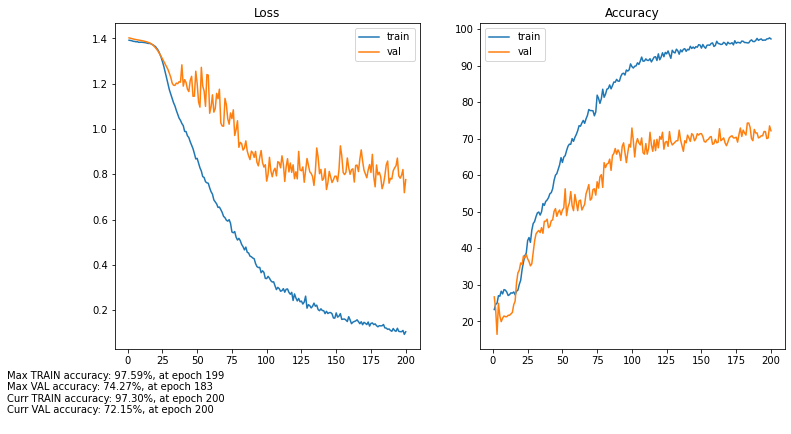

In [7]:
# Set up cross validation folds, and average accuracy tracker
kf = KFold(n_splits=5, random_state=None, shuffle=True)
avg_accuracy=0
kcount = 1

for k_train_index, k_val_index in kf.split(X_train_valid):
  ## Only compute 1 fold due to computation time:
  if kcount==2:
    break
  ## Print fold
  print('-- Fold [{}/5] --'.format(kcount))

  ## Create this fold's dataloader
  SEGMENT = True
  VOTE = False
  window_width = 900
  stride = 10
  num_slices = int((1000-window_width)/stride+1)

  dataloaders = make_dataloaders(k_train_index, k_val_index, X_train_valid, y_train_valid, X_test, y_test, 
                                 cut=SEGMENT, window_width=window_width, stride=stride, num_slices=num_slices)
  
  ## Create model, hyperpatameters, optimizer, loss function 
  weight_decay = 0.001
  model = Conv2(dropout=0.5).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay=weight_decay)
  loss_fn = nn.CrossEntropyLoss()
  num_epochs = 200

  ## Start training/validating/training
  # set up per epoch accuracy and loss trackers
  loss_tracker = {'train':[], 'val':[]}
  accuracy_tracker = {'train':[], 'val':[]}
  best_model_params = [0, model]

  for epoch in range(num_epochs): 
    logs = {}
    # train on training samples
    model, epoch_loss_avg, epoch_accuracy = train(model, optimizer, loss_fn, dataloaders, device, epoch)
    loss_tracker['train'].append(epoch_loss_avg)
    accuracy_tracker['train'].append(epoch_accuracy)

    # evalutate on validation samples 
    epoch_loss_avg, epoch_accuracy, best_model_params = validate(model, optimizer, loss_fn, dataloaders, device, epoch, best_model_params)
    loss_tracker['val'].append(epoch_loss_avg)
    accuracy_tracker['val'].append(epoch_accuracy)

  # plot train/validation graph
  make_plot(num_epochs, loss_tracker, accuracy_tracker, saveplot=False)
  # get model weights from the epoch with the highest validation accuracy
  _, final_best_model = best_model_params
  thisacc = finaltest(final_best_model, dataloaders, device)
  print('Test accuracy from the best model during fold [{}] is: [{:.2f}%]'.format(kcount, thisacc))
  kcount += 1
  avg_accuracy += thisacc

print('Average test accuracy of 5-fold validation: [{:.2f}]'.format(avg_accuracy/5))